In [20]:
import pandas as pd

# Load each file
automotive = pd.ExcelFile('automotive.xlsx')
consultant = pd.ExcelFile('consultant.xlsx')
customers = pd.ExcelFile('customers.xlsx')

# Display sheet names for each file
print("Automotive Sheets:", automotive.sheet_names)
print("Consultant Sheets:", consultant.sheet_names)
print("Customers Sheets:", customers.sheet_names)

# Load specific sheets (adjust sheet names as needed)
auto_data = automotive.parse(automotive.sheet_names[0])
consultant_data = consultant.parse(consultant.sheet_names[0])
customers_data = customers.parse(customers.sheet_names[0])

# Preview the data
print(auto_data.head())
print(consultant_data.head())
print(customers_data.head())


Automotive Sheets: ['Sheet1']
Consultant Sheets: ['consultant']
Customers Sheets: ['Updated_Customers_DataFrame']
   sale_id  loan_id  vehicle_id  customer_id  consultant_id           make  \
0      877      877         266          743             11  Mercedes-Benz   
1      306      306         399          262              2         Toyota   
2      159      159         594          136              3          Mazda   
3      844      844         980          715             11          Volvo   
4      860      860         556          729              8          Acura   

     model  year  acquisition_price  sale_price  ...  interest_rate  \
0  E-Class  2004               3987        5339  ...             12   
1    Camry  2006               2836        4308  ...              4   
2   Mazda6  2009              26348       35925  ...             10   
3     XC90  2003               1010        2429  ...              5   
4      RDX  2014              48854       49012  ...          

In [21]:
import pandas as pd

# Merge automotive data with customer data on customer_id to include debt-to-income ratio
auto_customers_merged = pd.merge(auto_data, customers_data, on='customer_id', how='left')

# Identify customers with high debt-to-income ratios (e.g., ratio > 0.5)
high_dti_customers = auto_customers_merged[auto_customers_merged['debt_to_income_ratio'] > 0.5]

# Calculate loan approval time (days between application_date and approval_date)
auto_data['approval_time_days'] = (pd.to_datetime(auto_data['approval_date']) -
                                   pd.to_datetime(auto_data['application_date'])).dt.days

# Analyze approval time by credit score
approval_time_analysis = auto_data.groupby('customer_credit_score')['approval_time_days'].mean()

# Display results
print("High Debt-to-Income Customers:")
print(high_dti_customers[['customer_id', 'debt_to_income_ratio']])

print("\nAverage Approval Time by Credit Score:")
print(approval_time_analysis)

print("\nApproval Time Overview:")
print(auto_data[['customer_id', 'approval_time_days', 'customer_credit_score']])


High Debt-to-Income Customers:
      customer_id  debt_to_income_ratio
0             743                  0.51
7              48                  0.87
8              48                  0.87
11            467                  0.68
13            457                  0.55
...           ...                   ...
1313           63                  0.53
1314          485                  0.62
1317           66                  0.56
1320          431                  0.93
1321          431                  0.93

[456 rows x 2 columns]

Average Approval Time by Credit Score:
customer_credit_score
435    18.783333
436    25.000000
438    16.000000
439    14.000000
440    17.000000
         ...    
841    23.000000
842    11.000000
843    21.500000
844    16.000000
845    16.000000
Name: approval_time_days, Length: 345, dtype: float64

Approval Time Overview:
     customer_id  approval_time_days  customer_credit_score
0            743                  13                    435
1            262 

In [22]:
import pandas as pd
import numpy as np

# 1. Credit Score Insights
# Average customer credit scores for approved loans
average_credit_score = auto_data['customer_credit_score'].mean()

# Correlation between credit score and interest rate
credit_interest_corr = auto_data[['customer_credit_score', 'interest_rate']].corr().iloc[0, 1]

# 2. Income and Loan Amount Relationship
# Merge automotive data with customer data to include income information
loan_income_data = pd.merge(auto_data, customers_data, on='customer_id', how='left')

# Analyze relationship between customer income and loan amount (total_loan_payments)
income_loan_corr = loan_income_data[['annual_income', 'total_loan_payments']].corr().iloc[0, 1]

# 3. Gender and Financing
# Analyze financing behavior and loan terms by gender
gender_analysis = loan_income_data.groupby('gender').agg(
    avg_loan_amount=('total_loan_payments', 'mean'),
    avg_interest_rate=('interest_rate', 'mean'),
    avg_monthly_payment=('monthly_payment', 'mean')
)

# Display results
print("1. Credit Score Insights")
print(f"Average Customer Credit Score: {average_credit_score}")
print(f"Correlation Between Credit Score and Interest Rate: {credit_interest_corr}")

print("\n2. Income and Loan Amount Relationship")
print(f"Correlation Between Income and Loan Amount: {income_loan_corr}")

print("\n3. Gender and Financing Analysis")
print(gender_analysis)


1. Credit Score Insights
Average Customer Credit Score: 623.741
Correlation Between Credit Score and Interest Rate: -0.9799811032496213

2. Income and Loan Amount Relationship
Correlation Between Income and Loan Amount: -0.0638047693830021

3. Gender and Financing Analysis
        avg_loan_amount  avg_interest_rate  avg_monthly_payment
gender                                                         
Female     22106.591707           7.478469           368.456140
Male       21452.509353           7.378417           357.541007


In [23]:
# Consultant Performance Analysis

# Merge automotive data with consultant data on consultant_id
consultant_performance_data = pd.merge(auto_data, consultant_data, on='consultant_id', how='left')

# 1. Loan Origination by Consultant
# Total loans initiated and approved by each consultant
loans_by_consultant = consultant_performance_data.groupby('name').agg(
    total_loans=('loan_id', 'count'),
    approved_loans=('loan_id', lambda x: x.notnull().sum())
)

# Average loan amounts and terms handled by consultants
loan_amounts_terms = consultant_performance_data.groupby('name').agg(
    avg_loan_amount=('total_loan_payments', 'mean'),
    avg_loan_term=('monthly_payment', 'mean')
)

# 2. Commission Analysis
# Calculate commissions earned from financed deals (based on commission_rate)
consultant_performance_data['commission_earned'] = (
    consultant_performance_data['total_loan_payments'] *
    consultant_performance_data['commission_rate']
)

# Total commission by consultant
commission_analysis = consultant_performance_data.groupby('name').agg(
    total_commission=('commission_earned', 'sum')
)

# Combine all metrics into one DataFrame for summary
consultant_summary = loans_by_consultant.join(loan_amounts_terms).join(commission_analysis)

# Display the summary
print("Consultant Performance Summary:")
print(consultant_summary)


Consultant Performance Summary:
                  total_loans  approved_loans  avg_loan_amount  avg_loan_term  \
name                                                                            
Alex Johnson               80              80     22281.687500     371.337500   
Andrew Thomas              89              89     21096.067416     351.640449   
Chris Davis                89              89     21450.393258     357.539326   
Daniel Wilson              88              88     22705.340909     378.409091   
David Miller               85              85     22226.611765     370.482353   
Emily Taylor               79              79     22673.594937     377.886076   
Jessica Brown              62              62     21535.080645     358.887097   
John Smith                 71              71     22566.661972     376.098592   
Matthew Anderson           89              89     22382.258427     373.011236   
Michael Williams           87              87     19952.804598     332.528736

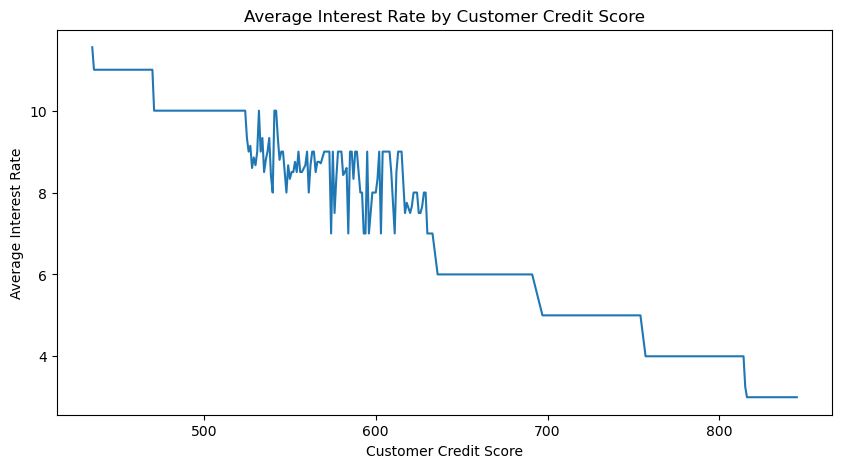

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Average interest rates by customer credit score
interest_by_credit = auto_data.groupby('customer_credit_score')['interest_rate'].mean()

# Plot: Interest Rate Distribution by Credit Score
plt.figure(figsize=(10, 5))
sns.lineplot(x=interest_by_credit.index, y=interest_by_credit.values)
plt.title('Average Interest Rate by Customer Credit Score')
plt.xlabel('Customer Credit Score')
plt.ylabel('Average Interest Rate')
plt.show()


/var/folders/z8/4pd0hcn95j18p09gptr8fftc0000gn/T/ipykernel_21001/641129945.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  interest_by_loan = auto_data.groupby(pd.cut(auto_data['total_loan_payments'], bins=10))['interest_rate'].mean()


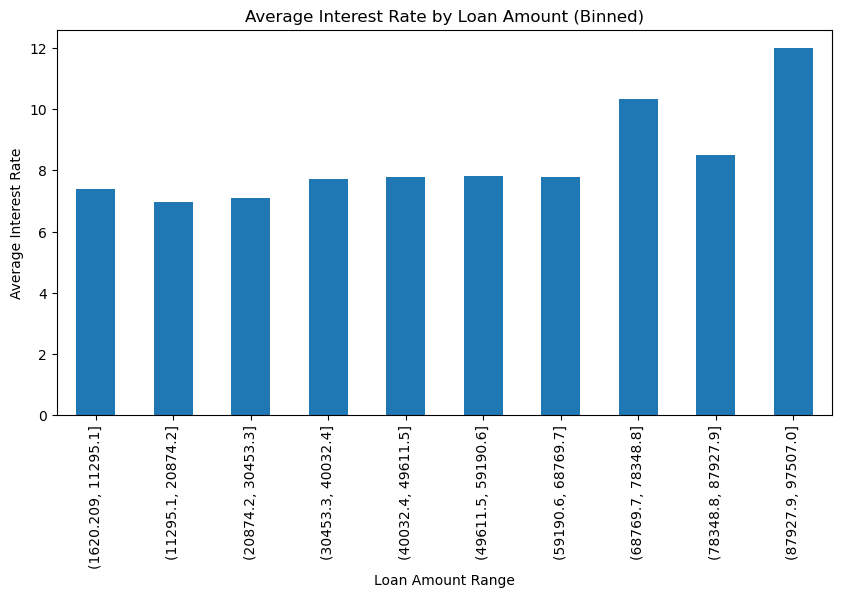

In [26]:
# Average interest rates by loan amount
interest_by_loan = auto_data.groupby(pd.cut(auto_data['total_loan_payments'], bins=10))['interest_rate'].mean()

# Plot: Interest Rate Distribution by Loan Amount
plt.figure(figsize=(10, 5))
interest_by_loan.plot(kind='bar')
plt.title('Average Interest Rate by Loan Amount (Binned)')
plt.xlabel('Loan Amount Range')
plt.ylabel('Average Interest Rate')
plt.show()


In [30]:
# Identify outliers using the IQR method
q1 = auto_data['interest_rate'].quantile(0.25)
q3 = auto_data['interest_rate'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = auto_data[(auto_data['interest_rate'] < lower_bound) | (auto_data['interest_rate'] > upper_bound)]

# Display outliers
print("Outliers in Interest Rates:")
print(outliers)

# Optionally save the outliers to a CSV file
outliers.to_csv('interest_rate_outliers.csv', index=False)


Outliers in Interest Rates:
Empty DataFrame
Columns: [sale_id, loan_id, vehicle_id, customer_id, consultant_id, make, model, year, acquisition_price, sale_price, add_ons, ttl, total_price, profit, down_payment, loan_amount, loan_term_months, interest_rate, monthly_payment, total_loan_payments, Final total (all_in_cost), application_date, approval_date, loan_start_date, sale_date, days_on_lot, customer_credit_score, approval_time_days]
Index: []

[0 rows x 28 columns]


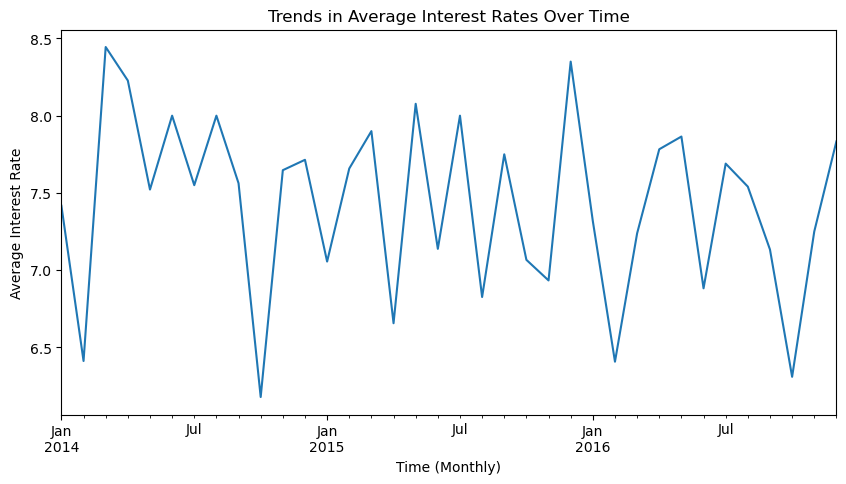

In [28]:
# Convert loan_start_date to datetime
auto_data['loan_start_date'] = pd.to_datetime(auto_data['loan_start_date'])

# Trends in average interest rates over time
interest_over_time = auto_data.groupby(auto_data['loan_start_date'].dt.to_period('M'))['interest_rate'].mean()

# Plot: Interest Rates Over Time
plt.figure(figsize=(10, 5))
interest_over_time.plot()
plt.title('Trends in Average Interest Rates Over Time')
plt.xlabel('Time (Monthly)')
plt.ylabel('Average Interest Rate')
plt.show()


In [29]:
results = {
    "Average Interest by Credit Score": interest_by_credit,
    "Average Interest by Loan Amount (Binned)": interest_by_loan,
    "Interest Rate Outliers": outliers,
    "Interest Rate Trends Over Time": interest_over_time
}

for key, value in results.items():
    print(f"{key}:\n{value}\n")


Average Interest by Credit Score:
customer_credit_score
435    11.55
436    11.00
438    11.00
439    11.00
440    11.00
       ...  
841     3.00
842     3.00
843     3.00
844     3.00
845     3.00
Name: interest_rate, Length: 345, dtype: float64

Average Interest by Loan Amount (Binned):
total_loan_payments
(1620.209, 11295.1]     7.406332
(11295.1, 20874.2]      6.953488
(20874.2, 30453.3]      7.109091
(30453.3, 40032.4]      7.722973
(40032.4, 49611.5]      7.782609
(49611.5, 59190.6]      7.805556
(59190.6, 68769.7]      7.769231
(68769.7, 78348.8]     10.333333
(78348.8, 87927.9]      8.500000
(87927.9, 97507.0]     12.000000
Name: interest_rate, dtype: float64

Interest Rate Outliers:
Empty DataFrame
Columns: [sale_id, loan_id, vehicle_id, customer_id, consultant_id, make, model, year, acquisition_price, sale_price, add_ons, ttl, total_price, profit, down_payment, loan_amount, loan_term_months, interest_rate, monthly_payment, total_loan_payments, Final total (all_in_cost), appl

In [32]:
# Merge automotive data with customer data, resolving duplicate column names
auto_customers_merged = pd.merge(
    auto_data, customers_data, on='customer_id', how='left', suffixes=('_auto', '_cust')
)

# Check columns in the merged DataFrame
print("Columns in auto_customers_merged:")
print(auto_customers_merged.columns)

# Use the appropriate column for customer_credit_score (e.g., 'customer_credit_score_auto' or 'customer_credit_score_cust')
auto_customers_merged['default'] = (auto_customers_merged['customer_credit_score_auto'] < 600) | \
                                   (auto_customers_merged['debt_to_income_ratio'] > 0.5)

# Features for prediction
features = ['customer_credit_score_auto', 'debt_to_income_ratio', 'annual_income', 'monthly_payment']
target = 'default'

# Prepare data
X = auto_customers_merged[features]
y = auto_customers_merged[target]

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Columns in auto_customers_merged:
Index(['sale_id', 'loan_id', 'vehicle_id', 'customer_id', 'consultant_id',
       'make', 'model', 'year', 'acquisition_price', 'sale_price', 'add_ons',
       'ttl', 'total_price', 'profit', 'down_payment', 'loan_amount',
       'loan_term_months', 'interest_rate', 'monthly_payment',
       'total_loan_payments', 'Final total (all_in_cost)', 'application_date',
       'approval_date', 'loan_start_date', 'sale_date', 'days_on_lot',
       'customer_credit_score_auto', 'approval_time_days', 'first_name',
       'last_name', 'age', 'gender', 'customer_credit_score_cust',
       'annual_income', 'employement_status', 'region', 'address',
       'debt_to_income_ratio'],
      dtype='object')
Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.98      0.99       163
        True       0.99      1.00      0.99       234

    accuracy                           0.99       397
   macro avg       0.99     

In [33]:
# Calculate average loan terms (in months)
auto_data['loan_term_months'] = auto_data['total_loan_payments'] / auto_data['monthly_payment']

# Analyze repayment success rates
repayment_success = auto_data.groupby('customer_id').agg(
    total_loans=('loan_id', 'count'),
    avg_loan_term=('loan_term_months', 'mean'),
    repayment_rate=('loan_term_months', lambda x: (x > 0).mean())
)

# Display results
print("Loan Term Analysis:")
print(repayment_success.head())

# Save to CSV for further exploration if needed
repayment_success.to_csv('loan_term_analysis.csv', index=False)


Loan Term Analysis:
             total_loans  avg_loan_term  repayment_rate
customer_id                                            
1                      1      59.797753             1.0
2                      1      60.012129             1.0
3                      2      59.849695             1.0
4                      1      59.981203             1.0
5                      1      59.908333             1.0


Columns in auto_customers_merged:
Index(['sale_id', 'loan_id', 'vehicle_id', 'customer_id', 'consultant_id',
       'make', 'model', 'year', 'acquisition_price', 'sale_price', 'add_ons',
       'ttl', 'total_price', 'profit', 'down_payment', 'loan_amount',
       'loan_term_months', 'interest_rate', 'monthly_payment',
       'total_loan_payments', 'Final total (all_in_cost)', 'application_date',
       'approval_date', 'loan_start_date', 'sale_date', 'days_on_lot',
       'customer_credit_score_auto', 'approval_time_days', 'first_name',
       'last_name', 'age', 'gender', 'customer_credit_score_cust',
       'annual_income', 'employement_status', 'region', 'address',
       'debt_to_income_ratio', 'default'],
      dtype='object')


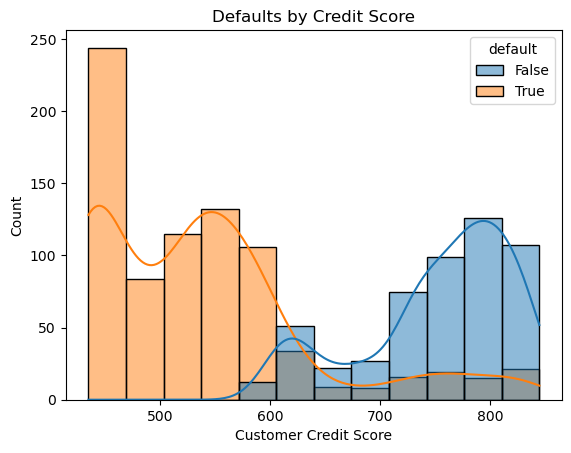

In [35]:
# Check column names in auto_customers_merged
print("Columns in auto_customers_merged:")
print(auto_customers_merged.columns)

# Update the column reference for customer_credit_score (use the correct name after merge)
# Assuming the correct name is 'customer_credit_score_auto' or 'customer_credit_score_cust'
sns.histplot(data=auto_customers_merged, x='customer_credit_score_auto', hue='default', kde=True)
plt.title('Defaults by Credit Score')
plt.xlabel('Customer Credit Score')
plt.ylabel('Count')
plt.show()
